## 📘 RNN-based Prediction of Remaining Useful Life (RUL) Using NASA Turbofan Dataset

This notebook provides an educational, end-to-end walkthrough of how to build a **Recurrent Neural Network (RNN)** model to predict the **Remaining Useful Life (RUL)** of turbofan jet engines using the publicly available **NASA CMAPSS-style dataset**.

<img src="Turbofan-operation-lbp.png" alt="Turbofan" width="500">

### 📊 Dataset Overview

The dataset contains run-to-failure simulation data of multiple turbofan engines. Each engine is operated until failure, and at each time-cycle, various operational settings and sensor readings are recorded.

Each row in the dataset represents **one time-step** for a specific engine and includes:

- **unit_number** – Engine identifier  
- **time_cycles** – Time step in the engine’s operational life  
- **setting_1, setting_2, setting_3** – Operational settings  
- **s_1 to s_21** – Sensor measurements (temperatures, pressures, rotational speeds, fuel-air ratios, etc.)  
- **RUL** – Remaining Useful Life (in cycles) until engine failure (the prediction target)

The task is to use multivariate sensor readings and historical degradation patterns to estimate how many cycles remain before failure.

### 🎯 Goal of This Notebook

The goal of this notebook is to demonstrate **how to model sequential engine data** using an RNN for RUL prediction. Specifically, this notebook will guide you through:

#### ✅ Data Preparation
- Loading and exploring the dataset  
- Sorting data per engine by time  
- Splitting data into training, validation, and test engines  
- Scaling sensor features and target RUL  
- Creating fixed-length sequences for RNN input  

#### 🧠 Model Development
- Building a simple and interpretable **RNN** using TensorFlow/Keras  
- Training the model to learn temporal degradation patterns  
- Visualizing training and validation loss  

#### 📈 Evaluation & Visualization
- Predicting RUL on unseen test sequences  
- Inverse-transforming predictions back into real RUL units  
- Computing error metrics such as RMSE  
- Plotting predicted vs. true RUL values for comparison  

### 🧩 Why Use RNNs for RUL Prediction?

RNNs are well-suited for time-series modeling

---

### 1️⃣ Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

### 2️⃣ 📦Load Dataset

In [ ]:
url = "https://raw.githubusercontent.com/Dr-AlaaKhamis/ISE518/refs/heads/main/datasets/nasa_rul.csv"
df = pd.read_csv(url)
print("Shape:", df.shape)
df.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### 3️⃣ Exploratory data analysis

<Axes: >

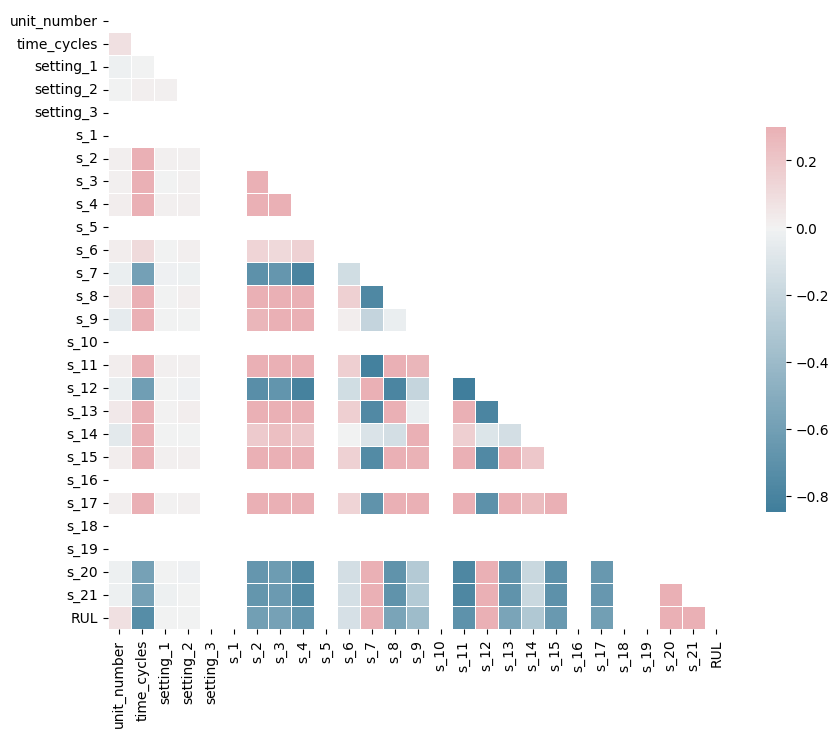

In [3]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Signal visualization

In [4]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

In [5]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

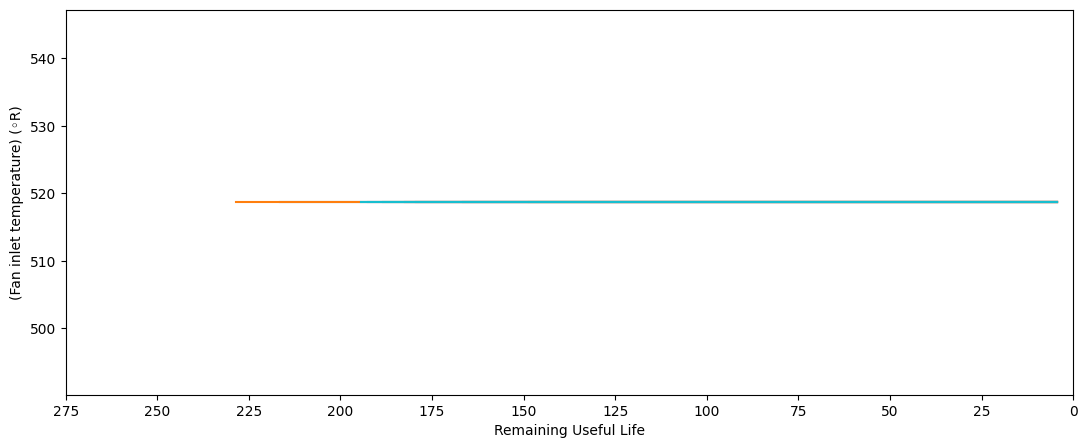

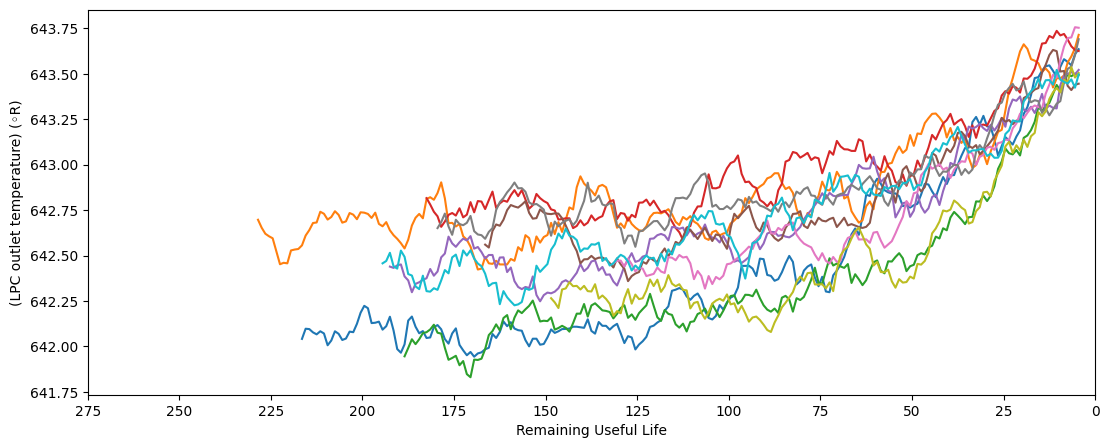

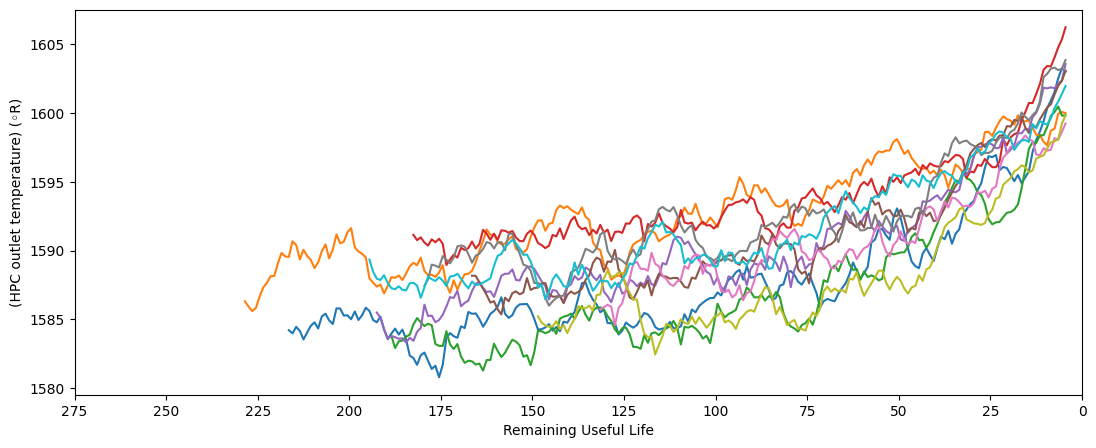

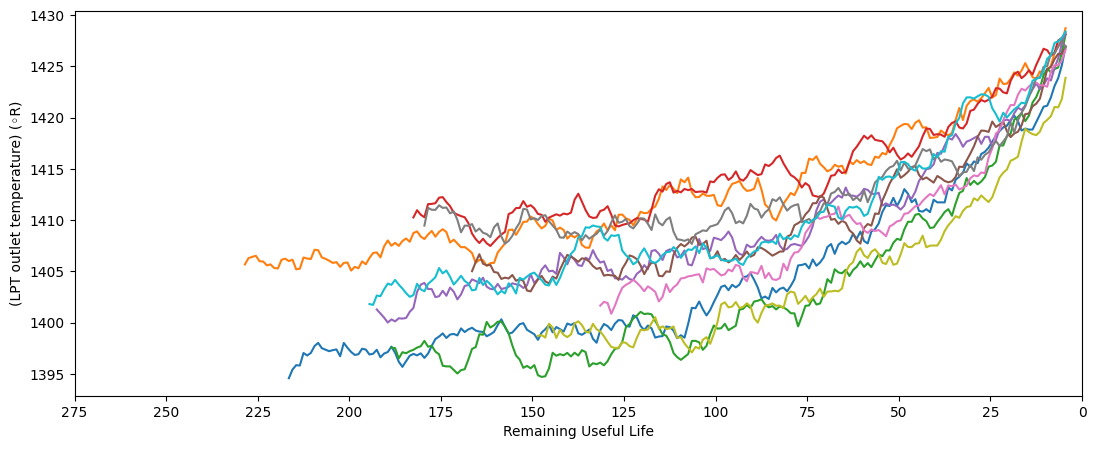

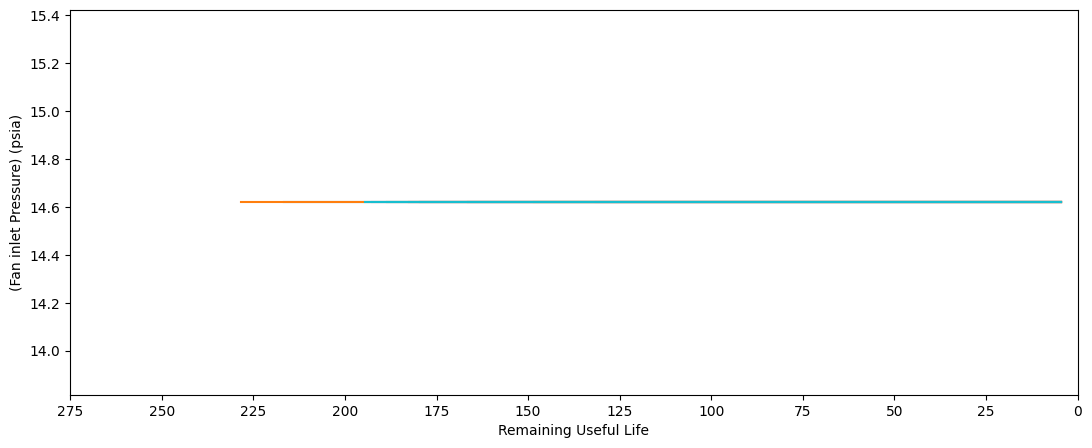

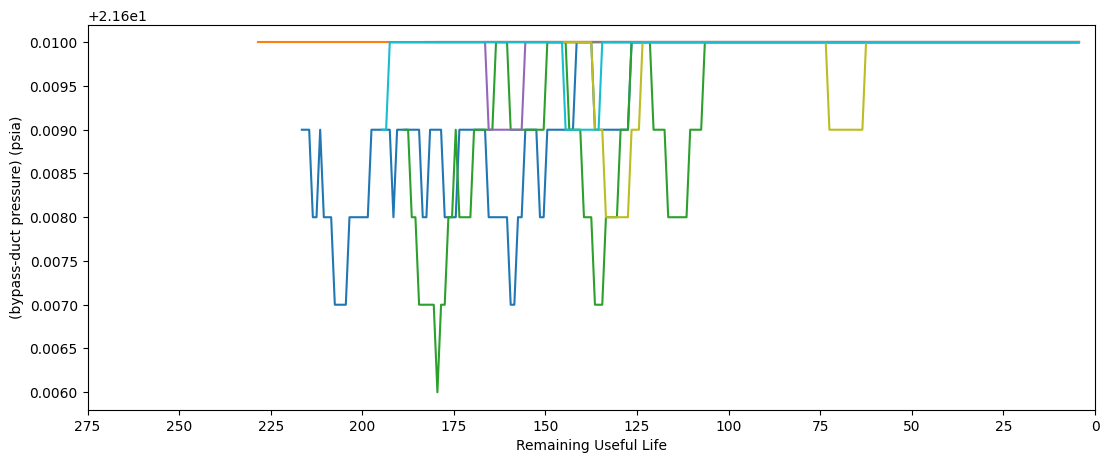

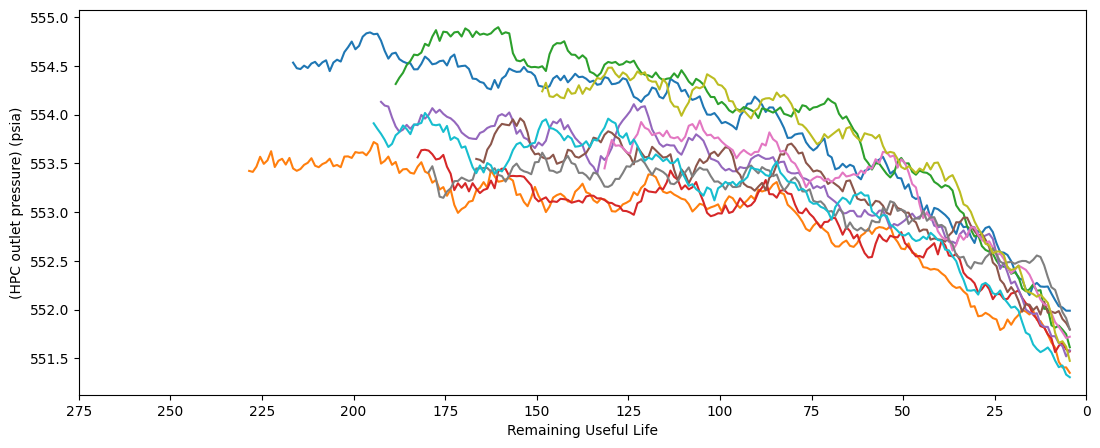

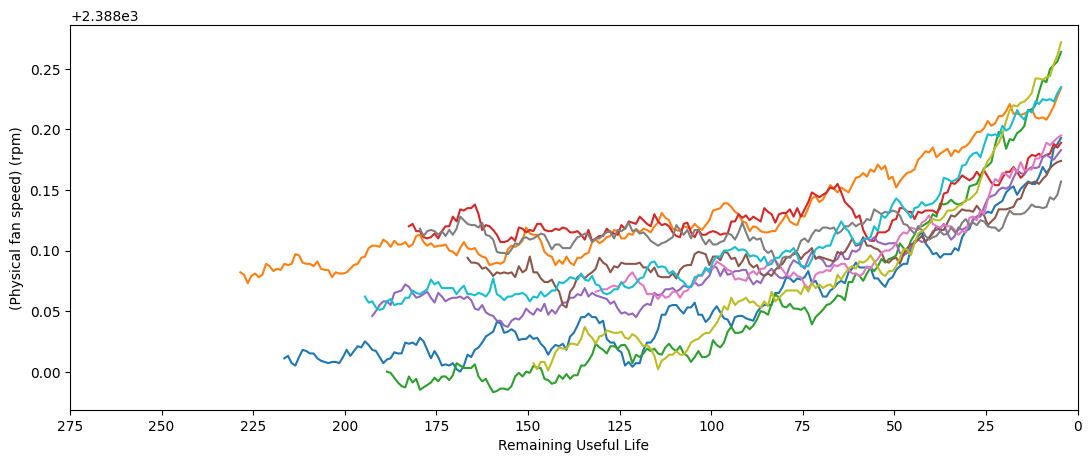

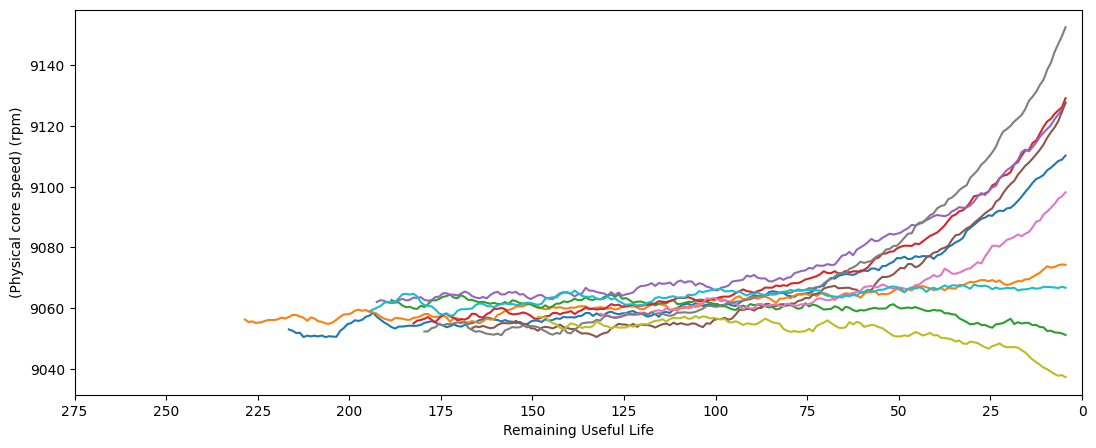

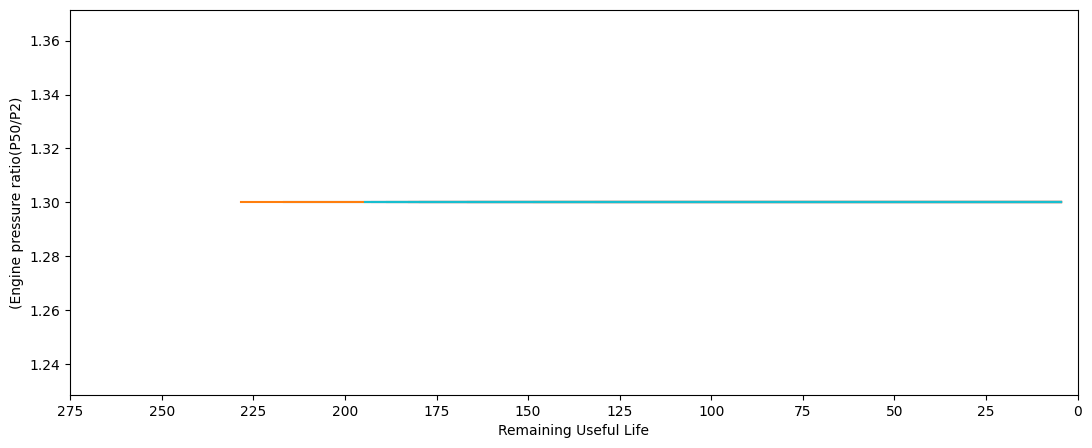

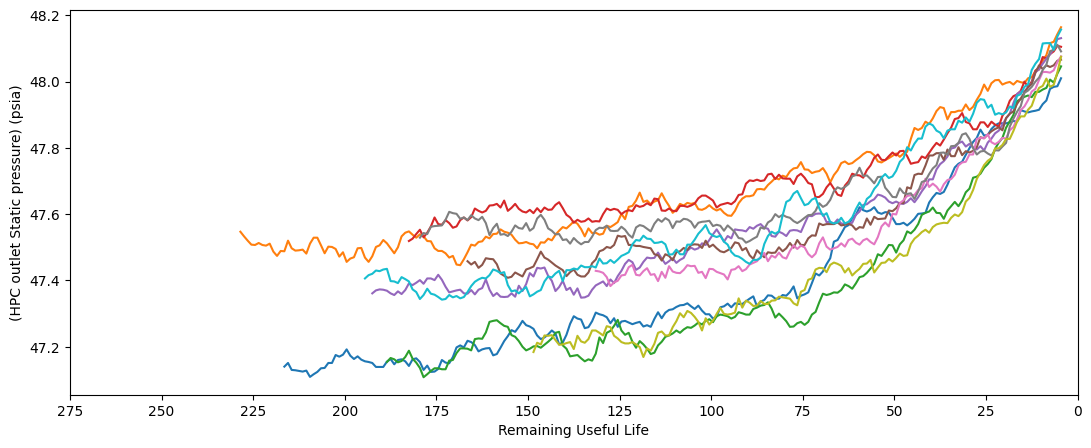

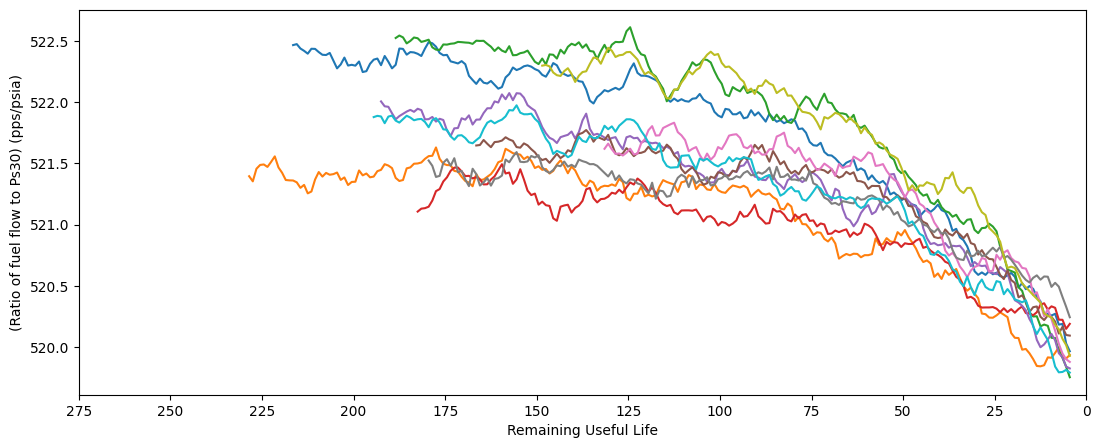

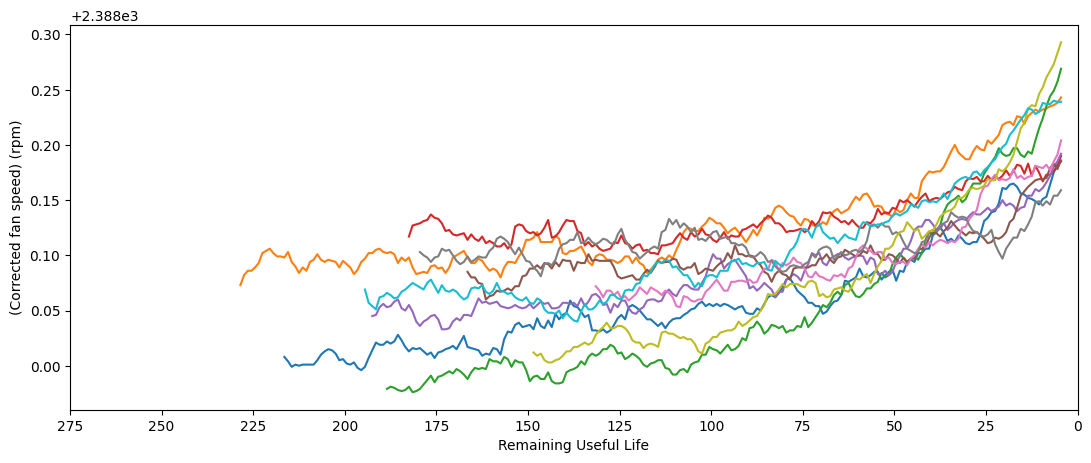

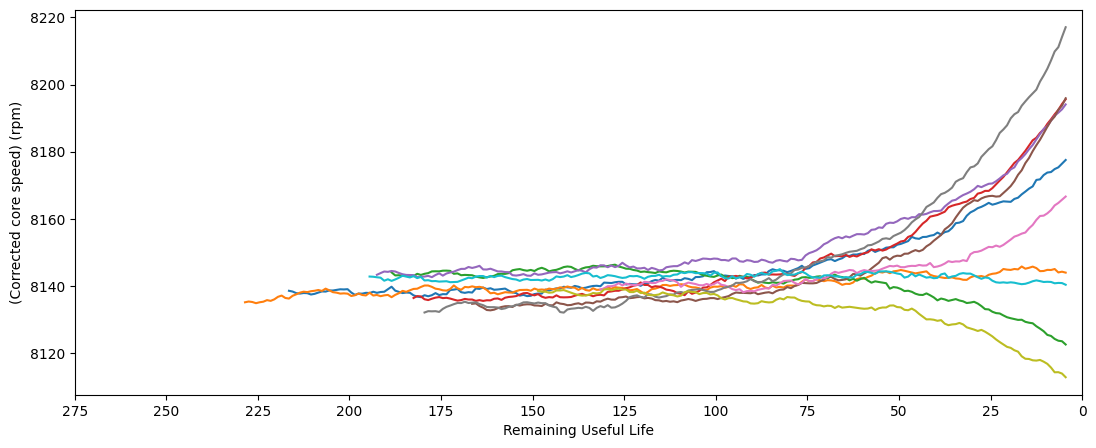

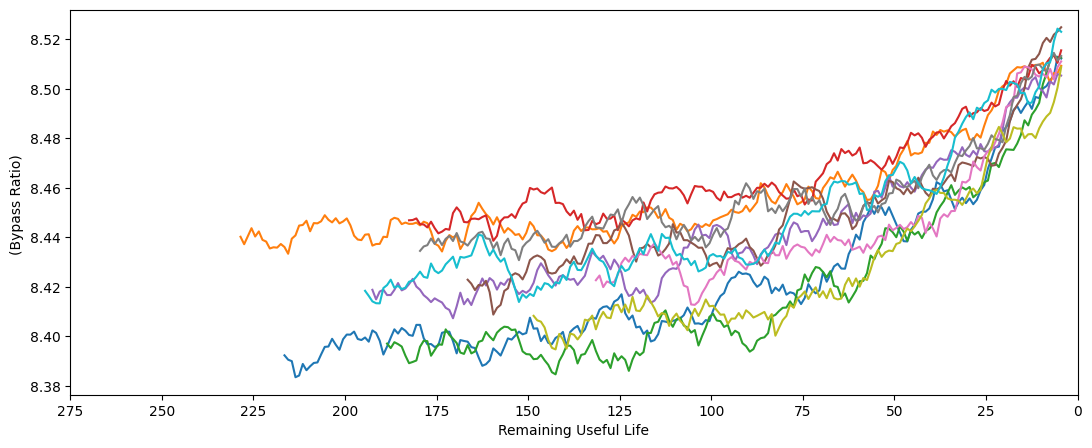

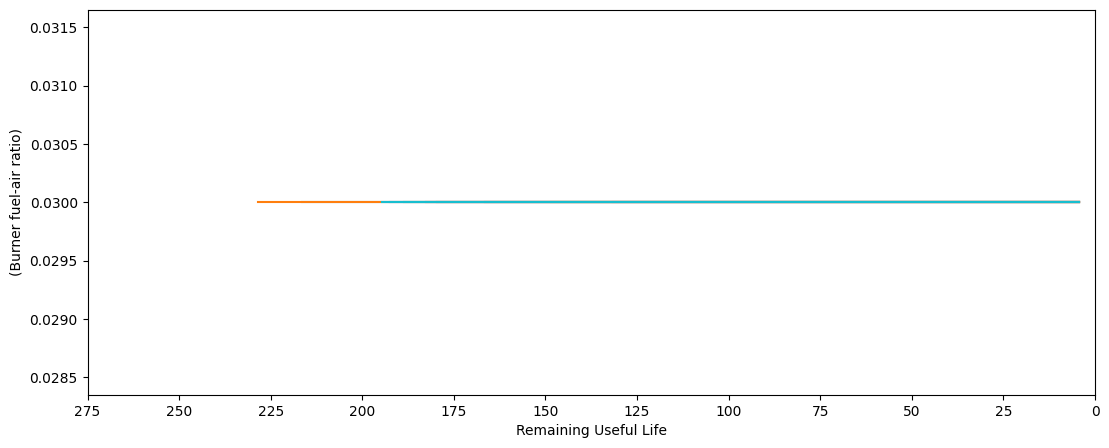

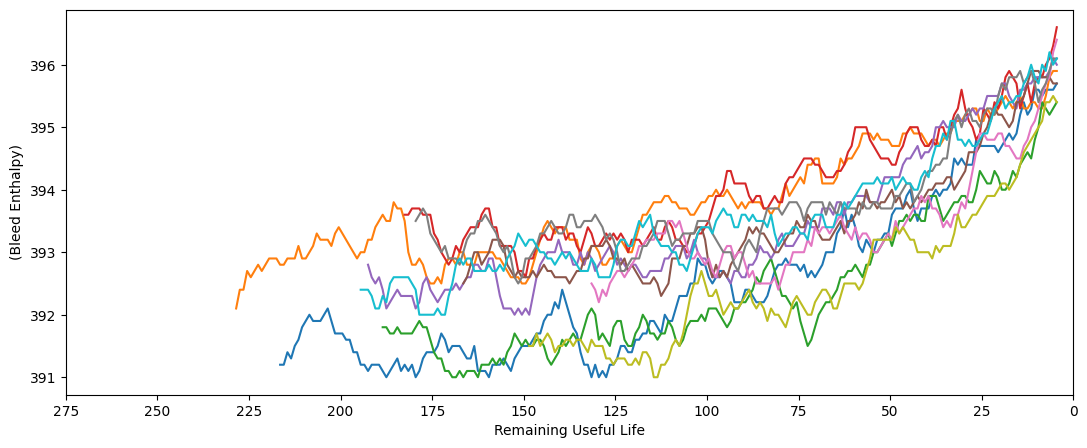

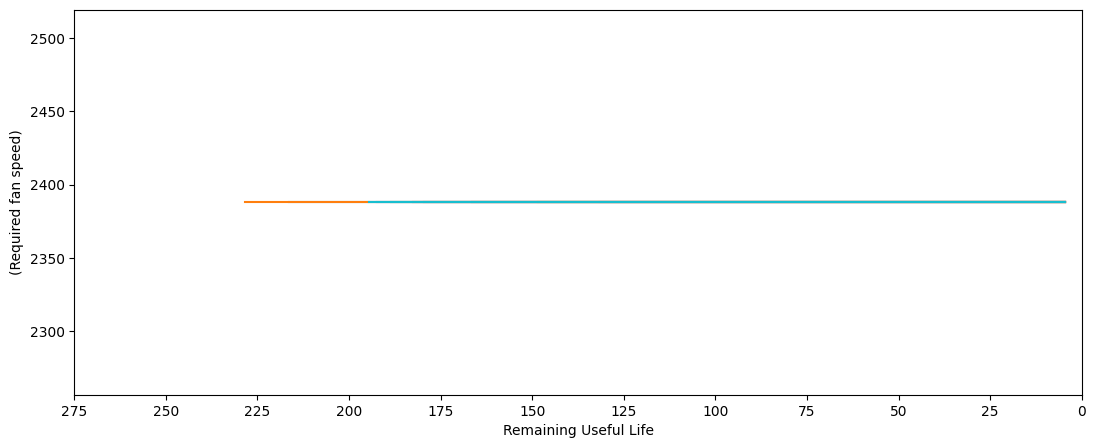

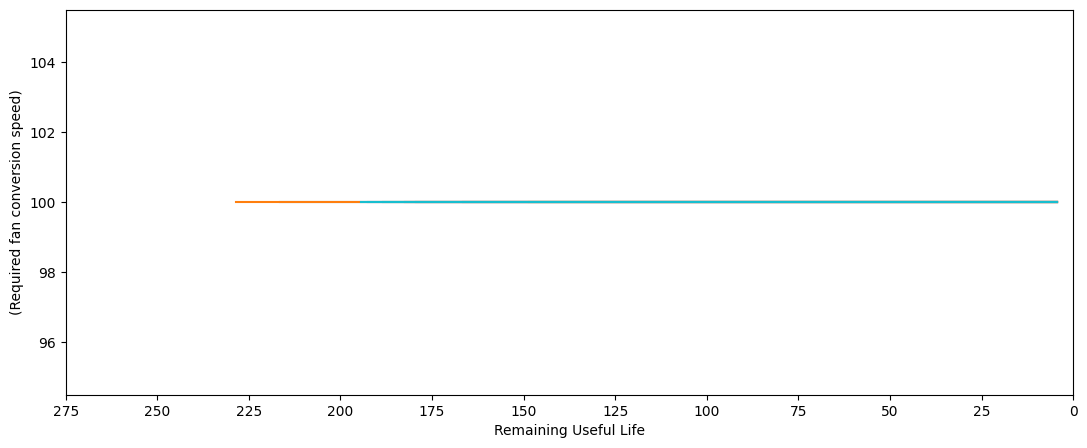

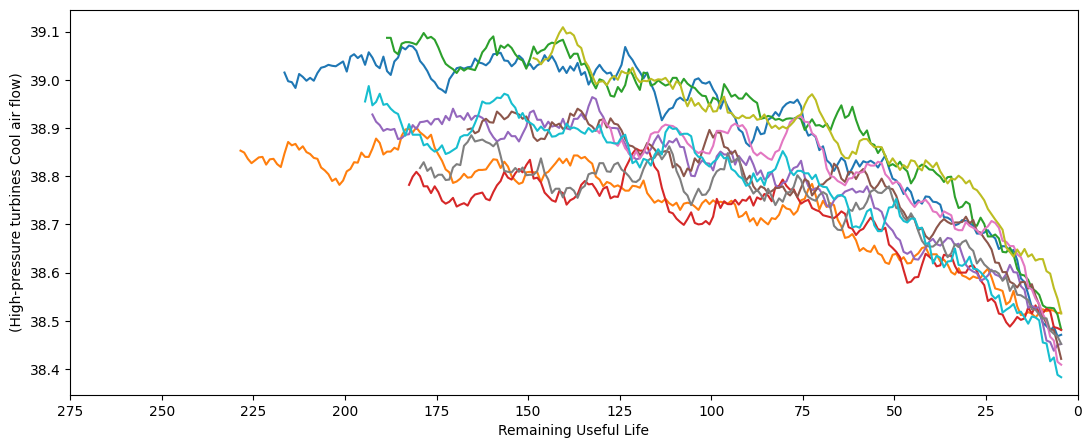

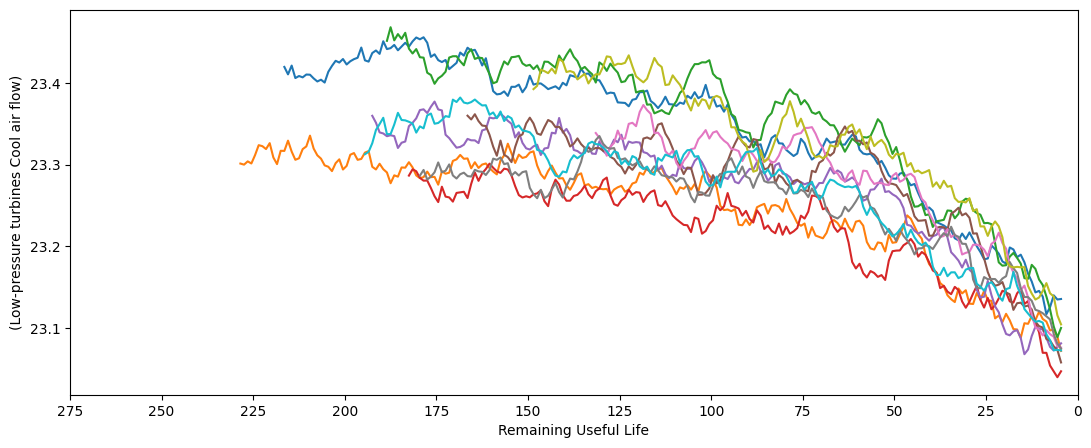

In [6]:
for i in range(1,22):
    try:
        plot_signal(df, Sensor_dictionary,'s_'+str(i))
    except:
        pass

### 4️⃣ Sort and Split by Engine

In [7]:
df = df.sort_values(["unit_number","time_cycles"]).reset_index(drop=True)
units = df['unit_number'].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
train_units, valid_units = train_test_split(train_units, test_size=0.2, random_state=42)

train_df = df[df.unit_number.isin(train_units)]
valid_df = df[df.unit_number.isin(valid_units)]
test_df  = df[df.unit_number.isin(test_units)]

### 5️⃣ Scale Features and Target

In [8]:
# Ensure splits are proper independent DataFrames
train_df = train_df.copy()
valid_df = valid_df.copy()
test_df  = test_df.copy()

index_cols = ['unit_number', 'time_cycles']
target_col = 'RUL'
feature_cols = [c for c in df.columns if c not in index_cols + [target_col]]

# ---------- SCALE FEATURES ----------
x_scaler = MinMaxScaler()

train_df.loc[:, feature_cols] = x_scaler.fit_transform(train_df[feature_cols])
valid_df.loc[:, feature_cols] = x_scaler.transform(valid_df[feature_cols])
test_df.loc[:, feature_cols]  = x_scaler.transform(test_df[feature_cols])

# ---------- SCALE TARGET ----------
y_scaler = MinMaxScaler()

train_df.loc[:, target_col] = y_scaler.fit_transform(train_df[[target_col]])
valid_df.loc[:, target_col] = y_scaler.transform(valid_df[[target_col]])
test_df.loc[:, target_col]  = y_scaler.transform(test_df[[target_col]])


### 6️⃣ Create Sequences

In [9]:
def create_sequences(df, seq_len, feat_cols, target_col):
    X, y = [], []
    for unit in df.unit_number.unique():
        unit_data = df[df.unit_number==unit]
        feats = unit_data[feat_cols].values
        targs = unit_data[target_col].values
        for i in range(len(unit_data)-seq_len+1):
            X.append(feats[i:i+seq_len])
            y.append(targs[i+seq_len-1])
    return np.array(X), np.array(y)

SEQ_LEN=30
X_train,y_train=create_sequences(train_df,SEQ_LEN,feature_cols,target_col)
X_valid,y_valid=create_sequences(valid_df,SEQ_LEN,feature_cols,target_col)
X_test,y_test=create_sequences(test_df,SEQ_LEN,feature_cols,target_col)

### 7️⃣ Build RNN Model

In [10]:
n_features=X_train.shape[2]
model=models.Sequential([
    layers.SimpleRNN(64,activation='tanh',input_shape=(SEQ_LEN,n_features)),
    layers.Dense(32,activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         5,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

### 8️⃣ Train Model

In [11]:
history=model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0186 - mae: 0.0977 - val_loss: 0.0159 - val_mae: 0.0988
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - mae: 0.0806 - val_loss: 0.0149 - val_mae: 0.0935
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - mae: 0.0793 - val_loss: 0.0204 - val_mae: 0.0958
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - mae: 0.0768 - val_loss: 0.0141 - val_mae: 0.0900
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - mae: 0.0757 - val_loss: 0.0171 - val_mae: 0.0876
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0109 - mae: 0.0741 - val_loss: 0.0178 - val_mae: 0.0910
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - mae: 0.0756 - val_loss: 0.0172 - val_mae: 0.0882
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0105 - mae: 0.0726 - val_loss: 0.0140 - val_mae: 0.0913
Epoch 9/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - l

### 9️⃣ Evaluate

In [12]:
y_pred_scaled=model.predict(X_test)
y_pred=y_scaler.inverse_transform(y_pred_scaled)
y_true=y_scaler.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(y_true,y_pred))
print("Test RMSE:",rmse)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test RMSE: 26.92845275642147


### 📊 🔟 Plot Results

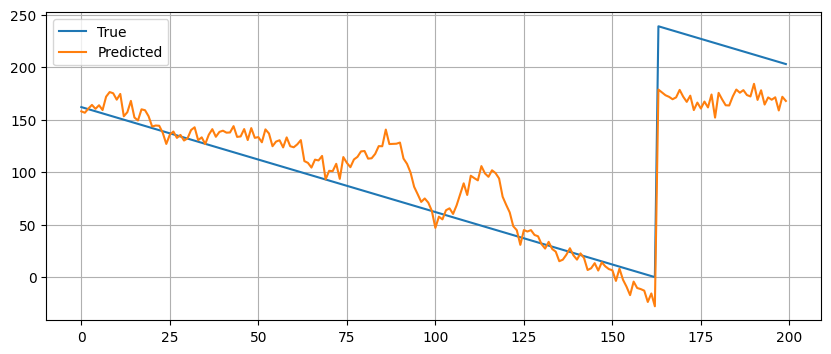

In [13]:
plt.figure(figsize=(10,4))
plt.plot(y_true[:200],label='True')
plt.plot(y_pred[:200],label='Predicted')
plt.legend(); plt.grid(); plt.show()

## 🔥 PyTorch Implementation of RNN for Remaining Useful Life (RUL) Prediction

In this section, we build a **Recurrent Neural Network (RNN)** model using **PyTorch** to predict the Remaining Useful Life (RUL) of turbofan engines based on sensor readings and operating conditions.

This implementation is fully compatible with the same preprocessed dataset and sequence windows used in the Keras version.

### 🧠 What This PyTorch Section Covers

- Defining a custom PyTorch RNN model  
- Building a PyTorch `Dataset` and `DataLoader`  
- Training the RNN for regression  
- Evaluating the model on test sequences  
- Computing RMSE and visualizing predictions  

PyTorch provides flexibility and control over the training loop while still being efficient for sequence modeling tasks such as RUL prediction.


***
### 1️⃣ PyTorch Imports

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


### 2️⃣ PyTorch Dataset for Sequences

In [15]:
class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Build datasets using already-prepared sequences

In [16]:
train_ds = RULDataset(X_train, y_train)
valid_ds = RULDataset(X_valid, y_valid)
test_ds  = RULDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

### 3️⃣ Define the PyTorch RNN Model

In [17]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]        # last time-step output
        out = self.fc(out)
        return out

### Model initialization

In [18]:
input_size = X_train.shape[2]
model = RNNRegressor(input_size=input_size, hidden_size=64).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 4️⃣ Training Loop

In [19]:
epochs = 25
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            valid_loss += criterion(y_pred, y_batch).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Valid Loss: {valid_loss/len(valid_loader):.4f}")

Epoch 1/25 | Train Loss: 0.0134 | Valid Loss: 0.0156
Epoch 2/25 | Train Loss: 0.0121 | Valid Loss: 0.0152
Epoch 3/25 | Train Loss: 0.0116 | Valid Loss: 0.0154
Epoch 4/25 | Train Loss: 0.0110 | Valid Loss: 0.0142
Epoch 5/25 | Train Loss: 0.0103 | Valid Loss: 0.0130
Epoch 6/25 | Train Loss: 0.0097 | Valid Loss: 0.0130
Epoch 7/25 | Train Loss: 0.0098 | Valid Loss: 0.0141
Epoch 8/25 | Train Loss: 0.0098 | Valid Loss: 0.0140
Epoch 9/25 | Train Loss: 0.0096 | Valid Loss: 0.0133
Epoch 10/25 | Train Loss: 0.0094 | Valid Loss: 0.0130
Epoch 11/25 | Train Loss: 0.0094 | Valid Loss: 0.0129
Epoch 12/25 | Train Loss: 0.0093 | Valid Loss: 0.0128
Epoch 13/25 | Train Loss: 0.0092 | Valid Loss: 0.0131
Epoch 14/25 | Train Loss: 0.0091 | Valid Loss: 0.0129
Epoch 15/25 | Train Loss: 0.0093 | Valid Loss: 0.0127
Epoch 16/25 | Train Loss: 0.0090 | Valid Loss: 0.0124
Epoch 17/25 | Train Loss: 0.0091 | Valid Loss: 0.0125
Epoch 18/25 | Train Loss: 0.0091 | Valid Loss: 0.0140
Epoch 19/25 | Train Loss: 0.0088 | Va

### 5️⃣ Evaluation on Test Set

In [20]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds.append(y_pred.cpu().numpy())
        trues.append(y_batch.numpy())

y_pred_scaled = np.concatenate(preds).flatten()
y_true_scaled = np.concatenate(trues).flatten()

### Inverse transform (RUL real units)

In [21]:
# Inverse transform (RUL real units)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"\n🔥 PyTorch RNN Test RMSE: {rmse:.2f}")


🔥 PyTorch RNN Test RMSE: 25.80


### 6️⃣ Plot Predictions

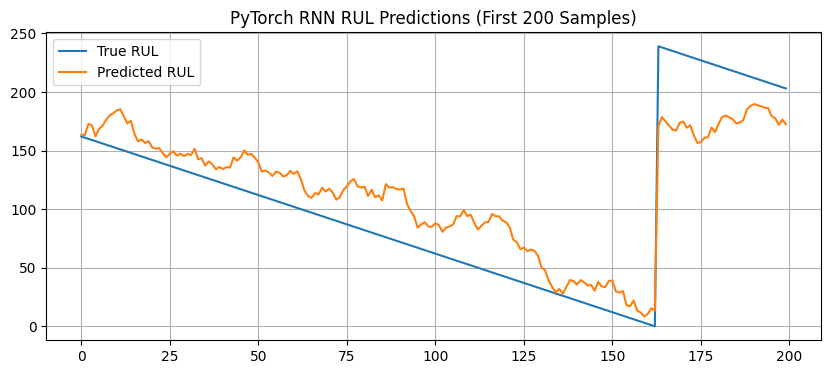

In [22]:
plt.figure(figsize=(10,4))
plt.plot(y_true[:200], label="True RUL")
plt.plot(y_pred[:200], label="Predicted RUL")
plt.legend(); plt.grid()
plt.title("PyTorch RNN RUL Predictions (First 200 Samples)")
plt.show()